# GOES Mesoscale Sector True Color Imagery

This notebook generates mesoscale sector true color imagery from channels 1-3 from the ABI Level 1B data.

In [1]:
import sys
import numpy as np
import xarray as xr
import glob
import proplot as plot

sys.path.append('/home/disk/meso-home/jfinlon/impacts/github/IMPACTS/src')
from impacts_tools import er2_radar

The subroutines below also reside in *truecolor.py*

In [4]:
# Boost the contrast to make brights brighter and darks darker
def contrast_correction(color, contrast):
    """
    Modify the contrast of an RGB
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        C - contrast level
    """
    F = (259*(contrast + 255))/(255.*(259-contrast))
    COLOR = F*(color-.5)+.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    
    return COLOR

# Subroutine to load mesoscale sector data for a specific channel corresponding to a user-specified time
def get_goes(directory, user_time, sector=1, channel=1):
    '''
    Load mesoscale sector data from the file closest in time to the user-specified time.
    
    directory: Directory path where the mesoscale sector data are located [str]
    user_time: Datetime to use when looking at the closest satellite data
    sector: Mesoscale sector to use [int: 1 or 2]
    '''
    filelist = glob.glob(directory + 'OR_ABI-L1b-RadM' + str(sector) + '*.nc')
    td_min = 99999. # smallest time difference in directory between satellite data and user-defined time
    filename = None
    for files in filelist: # Loop through directory and find the file with the smallest timedelta to the user-defined time
        # COMMENT FOR NOW time_sat_str = datetime.strptime(files.split('_')[-1][1:14], '%Y%j%H%M%S')
        time_sat_str = files.split('_')[-1][1:14]
        time_sat = np.datetime64(time_sat_str[:4], 'Y') + np.timedelta64(int(time_sat_str[4:7])-1, 'D') + np.timedelta64(int(time_sat_str[7:9]), 'h')+np.timedelta64(
            int(time_sat_str[9:11]), 'm')+np.timedelta64(int(time_sat_str[11:]), 's')
        td = np.abs((time_sat - np.datetime64(user_time))/np.timedelta64(1, 's'))
        if td<td_min: # This file is the new closest time for the flight leg
            filename = files
            td_min = td
            
    if filename is None:
        print('No file found within 1 day of flight leg.')
        return None
    else:
        rad_refl_const = [726.721072, 663.274497, 441.868715] # constants for converting radiance to reflectance for Ch 01, 02, 03
        data = xr.open_dataset(filename)
        if channel==13: # Clean IR deals with brightness temperature, not radiance/reflectance...but will keep var names for simplicity
            rad = data['Rad'].values
#             refl_gamma = 1.4387752e4 / (10.3 * np.log(1.191042e8 / (10.3**5) / rad))
            planck_fk1 = 10803.29980#202263. data['planck_fk1'].values[0]
            planck_fk2 = 1392.73999#3698.18994140625
            planck_bc1 = 0.0755#0.4336099922657013
            planck_bc2 = 0.99975#0.9993900060653687
            refl_gamma = ( planck_fk2 / ( np.log((planck_fk1 / rad) + 1 )) - planck_bc1) / planck_bc2
        else:
            rad = data['Rad'].values
            refl = (rad * np.pi * 0.3) / rad_refl_const[channel-1]
            refl = np.clip(refl, 0., 1.) # reflectance <0 --> 0, >1 --> 1
            refl_gamma = np.power(refl, 1./2.2)
            # COMMENT FOR NOW refl_gamma = np.sqrt(refl)
        if channel==2:
            domain_shape = [1000, 1000]
            sh = domain_shape[0],refl_gamma.shape[0]//domain_shape[0],domain_shape[1],refl_gamma.shape[1]//domain_shape[1]
            refl_gamma = refl_gamma.reshape(sh).mean(-1).mean(1)
        return data, refl_gamma

        
def true_color(user_time, sector=1):
    '''
    Construct the true color image. Follows https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html.
    
    user_time: Time to use for the mesoscale sector data [str in YYYY-mm-ddTHH:MM:SS format]
    '''
    date = np.datetime_as_string(np.datetime64(user_time, 'D'))
    date_alt = date.replace('-', '')
    
    # Get the mesoscale sector data to make the true color image
    # [TODO] Support channel 13 clean IR when VIS isn't available
    [data_ch01, refl_ch01] = get_goes('/home/disk/bob/impacts/raw/goes16/MesoSectors/Channel01/'+date_alt+'/', user_time, sector=sector, channel=1) # blue
    [data_ch02, refl_ch02] = get_goes('/home/disk/bob/impacts/raw/goes16/MesoSectors/Channel02/'+date_alt+'/', user_time, sector=sector, channel=2) # red
    [data_ch03, refl_ch03] = get_goes('/home/disk/bob/impacts/raw/goes16/MesoSectors/Channel03/'+date_alt+'/', user_time, sector=sector, channel=3) # veggie green
    #[data_ch13, bt_ch13] = get_goes('/home/disk/bob/impacts/raw/goes16/Channel13/'+date_alt+'/', user_time, sector=1, channel=13) # clean IR
    # COMMENT FOR NOW refl_ch03_true = 0.48358168 * refl_ch02 + 0.45706946 * refl_ch01 + 0.06038137 * refl_ch03
    refl_ch03_true = 0.45 * refl_ch02 + 0.45 * refl_ch01 + 0.1 * refl_ch03
    refl_ch03_true = np.clip(refl_ch03_true, 0., 1.) # reflectance <0 --> 0, >1 --> 1
    truecolor = np.stack([refl_ch02, refl_ch03_true, refl_ch01], axis=2)
    truecolor_contrast = contrast_correction(truecolor, 105)

    # Get the satellite projection info
    sat_h = data_ch01['goes_imager_projection'].attrs['perspective_point_height'] # Satellite height
    sat_lon = data_ch01['goes_imager_projection'].attrs['longitude_of_projection_origin'] # Satellite longitude
    sat_sweep = data_ch01['goes_imager_projection'].attrs['sweep_angle_axis'] # Satellite sweep
    semi_major = data_ch01['goes_imager_projection'].attrs['semi_major_axis']
    semi_minor = data_ch01['goes_imager_projection'].attrs['semi_minor_axis']

    # The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
    # See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
    X = data_ch01['x'].values * sat_h
    Y = data_ch01['y'].values * sat_h

    # Get the lat/lon corners
    lon_min = data_ch01['geospatial_lat_lon_extent'].attrs['geospatial_westbound_longitude']
    lon_max = data_ch01['geospatial_lat_lon_extent'].attrs['geospatial_eastbound_longitude']
    lat_min = data_ch01['geospatial_lat_lon_extent'].attrs['geospatial_southbound_latitude']
    lat_max = data_ch01['geospatial_lat_lon_extent'].attrs['geospatial_northbound_latitude']
    
    # Set up the object
    tc = {}
    tc['R'] = refl_ch02
    tc['G_veggie'] = refl_ch03
    tc['G_true'] = refl_ch03_true
    tc['B'] = refl_ch01
    tc['RGB'] = truecolor
    tc['RGB_veggie'] = np.stack([refl_ch02, refl_ch03, refl_ch01], axis=2)
    tc['sat_height'] = sat_h
    tc['sat_lon'] = sat_lon
    tc['sat_sweep'] = sat_sweep
    tc['semi_major'] = semi_major
    tc['semi_minor'] = semi_minor
    tc['X_proj'] = X
    tc['Y_proj'] = Y
    tc['lon_min'] = lon_min
    tc['lon_max'] = lon_max
    tc['lat_min'] = lat_min
    tc['lat_max'] = lat_max
    
    return tc

Call the *true\_color()* routine to get the RGB values for the specified time and sector.

In [5]:
tc = true_color('2020-02-01T14:40:00', sector=2)

Gather the GPM DPR-Ku swath path.

In [6]:
dpr_file = '/home/disk/bob/impacts/raw/gpm_ku/202002/GPM2Ku6_uw3_20200201.143222_to_20200201.143921_033679_IMP.nc'
dpr = xr.open_dataset(dpr_file)
dpr_lon_grid, dpr_lat_grid = np.meshgrid(dpr.lon.values, dpr.lat.values)
dpr_swath = dpr.swath.squeeze()

# Get the swath boundaries
swath_lon1 = []; swath_lon2 = []
swath_lat1 = []; swath_lat2 = []
for i in range(dpr_lon_grid.shape[0]):
    bndry_inds = np.where(np.diff(dpr_swath.values[i,:])!=0.)[0]
    if len(bndry_inds)>0:
        swath_lon1 = np.append(swath_lon1, dpr_lon_grid[i, bndry_inds[0]+1])
        swath_lat1 = np.append(swath_lat1, dpr_lat_grid[i, bndry_inds[0]+1])
        if len(bndry_inds)>1:
            swath_lon2 = np.append(swath_lon2, dpr_lon_grid[i, bndry_inds[1]+1])
            swath_lat2 = np.append(swath_lat2, dpr_lat_grid[i, bndry_inds[1]+1])

Load the ER-2 track data and trim for the 1425-1450 UTC leg. Using the *er2read* subroutine is the easiest way right now.

In [7]:
hiwrap_fname = '/home/disk/bob/impacts/er2/HIWRAP/hdfFiles/IMPACTS_HIWRAP_L1B_RevA_20200201T113316_to_20200201T155257.h5'
hiwrap = er2_radar.er2read(hiwrap_fname, beam='nadir')#, atten_file=hiwrap_k_fname, max_roll=10., dbz_sigma=1, ldr_sigma=None, vel_sigma=1, width_sigma=1, dbz_min=-30., ldr_min=None, vel_min=-5., width_min=0.)
hiwrap.keys()

# Trim the nav info
start_time = '2020-02-01T14:30:00'
end_time = '2020-02-01T14:50:00'
time_inds = np.where((hiwrap['time']>=np.datetime64(start_time)) & (hiwrap['time']<=np.datetime64(end_time)))[0]
er2_lon = hiwrap['lon'][time_inds]
er2_lat = hiwrap['lat'][time_inds]

Plot the imagery with the *proplot* package (https://proplot.readthedocs.io/en/latest/)

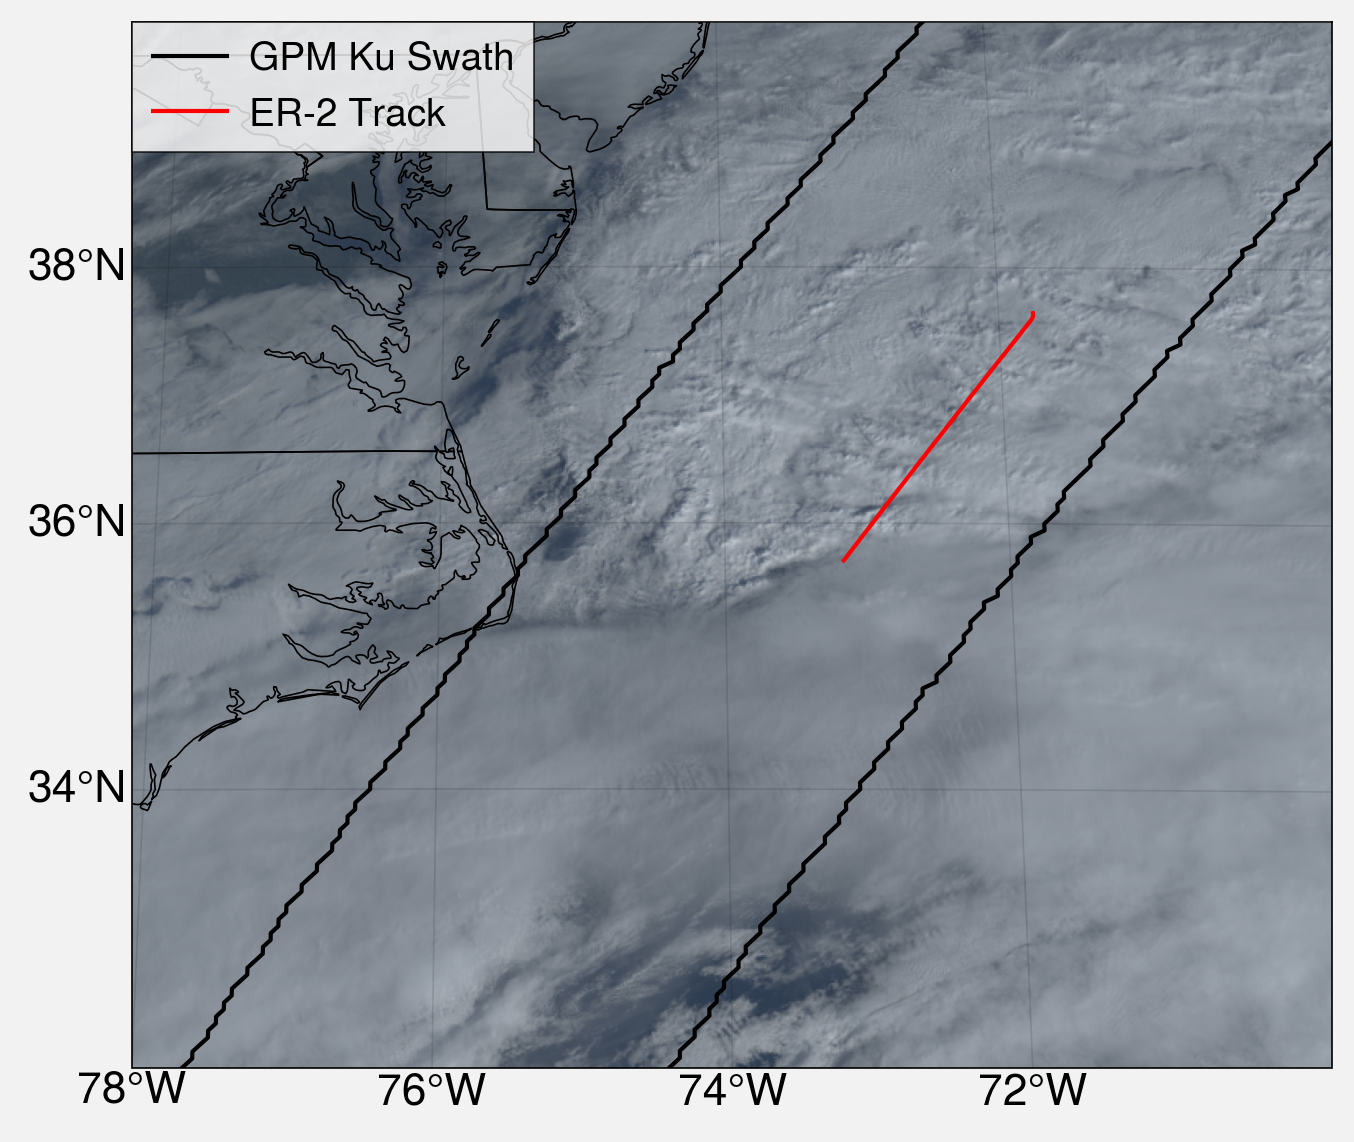

In [8]:
plot.rc.update({'savefigtransparent':False, 'reso':'hi', 'ticklabelsize':16, 'fontsize':16})
geos = plot.Proj('geos', lon_0=tc['sat_lon'], satellite_height=tc['sat_height'], sweep_axis='x')
proj = plot.Proj('lcc', lon_0=tc['sat_lon'])
fig, ax = plot.subplots(axwidth=6, proj=geos)
img1 = ax.imshow(tc['RGB'], origin='upper', transform=geos, extent=(tc['X_proj'].min(), tc['X_proj'].max(), tc['Y_proj'].min(), tc['Y_proj'].max()), zorder=1)
ax.plot(swath_lon1, swath_lat1, 'k-', label='GPM Ku Swath', zorder=2)
ax.plot(swath_lon2, swath_lat2, 'k-', zorder=2)
ax.plot(er2_lon, er2_lat, 'r-', label='ER-2 Track', zorder=2)
ax.legend(ncols=1, fontsize=14)
ax.format(lonlim=(-78, -70), latlim=(32, 40), lonlocator=[-78,-76,-74,-72], latlocator=[34,36,38])#, title='GOES-16 True Color 14:35 UTC 01 Feb 2020')
ax.format(land=False, lakes=True, borders=True, innerborders=True, latlabels='l', lonlabels='b')
# fig.savefig('/home/disk/meso-home/jfinlon/impacts/figures/papers/BAMS/goesmeso.truecolor.20200201T1440.pdf')
# fig.savefig('/home/disk/meso-home/jfinlon/impacts/figures/papers/BAMS/goesmeso.truecolor.20200201T1440.png', dpi=300, transparent=False)